In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [45]:
df=pd.read_csv('Sleep_Efficiency.csv')
df=df.drop(['ID','Age','Gender','Bedtime','Wakeup time','Sleep duration','REM sleep percentage','Deep sleep percentage','Light sleep percentage','Awakenings','Smoking status'],axis=1)
df['Caffeine consumption']=df['Caffeine consumption'].fillna(0)
df['Alcohol consumption']=df['Alcohol consumption'].fillna(0)
df['Exercise frequency']=df['Exercise frequency'].fillna(3)
df.head()


,Sleep efficiency,Caffeine consumption,Alcohol consumption,Exercise frequency
0,0.88,0.0,0.0,3.0
1,0.66,0.0,3.0,3.0
2,0.89,0.0,0.0,3.0
3,0.51,50.0,5.0,1.0
4,0.76,0.0,3.0,3.0


Linear Regression

In [52]:
y_target=df['Sleep efficiency']
X_data=df.drop(['Sleep efficiency'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

#선형회귀 OLS로 학습/예측/평가 수행
lr=LinearRegression()
lr.fit(X_train, y_train)
y_preds=lr.predict(X_test)
mse=mean_squared_error(y_test, y_preds)
rmse=np.sqrt(mse)

print("MSE: {0:3f}, RMSE:{1:.3F}".format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))

coeff=pd.Series(data=np.round(lr.coef_,5), index=X_data.columns)
coeff.sort_values(ascending=False)

MSE: 0.014820, RMSE:0.122
Variance score : 0.112


Exercise frequency      0.02468
Caffeine consumption    0.00018
Alcohol consumption    -0.03472
dtype: float64

Correlation

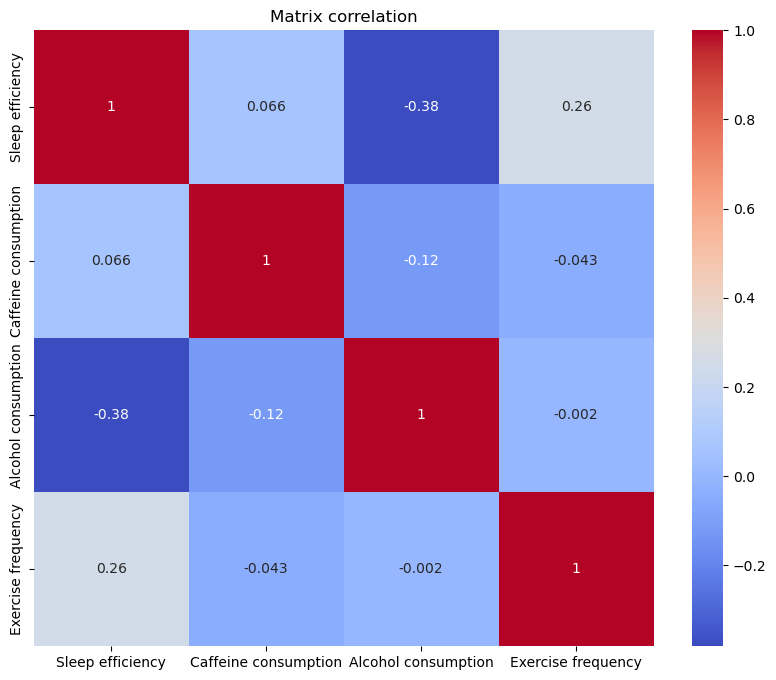

In [49]:
summary = df.describe()


# Matrice correlation
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matrix correlation")
plt.show()


Ridge Regression

In [61]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
ridge=Ridge(alpha=10)
neg_mse_scores=cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error",cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)
print("5 folds's each Negative MSE scores:",np.round(neg_mse_scores,3))
print("5 folds;s each RMSE scores:", np.round(rmse_scores,3))
print("Average RMSE: {0:.3f}".format(avg_rmse))

alphas=[0,0.1,1,10,100]
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    
coeff_df=pd.DataFrame()
for pos, alpha in enumerate(alphas):
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    coeff=pd.Series(data=ridge.coef_,index=X_data.columns)
    colname='alpha:'+str(alpha)
    coeff_df[colname]=coeff
    coeff=coeff.sort_values(ascending=False)

ridge_alphas=[0,0.1,1,10,100]
sort_column='alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

5 folds's each Negative MSE scores: [-0.014 -0.015 -0.014 -0.018 -0.013]
5 folds;s each RMSE scores: [0.118 0.123 0.117 0.134 0.112]
Average RMSE: 0.121


,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
Exercise frequency,0.024282,0.024279,0.024256,0.024021,0.021907
Caffeine consumption,0.000142,0.000142,0.000142,0.000143,0.000154
Alcohol consumption,-0.031684,-0.031682,-0.031657,-0.031413,-0.029165


Lasso Regression

In [74]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df=pd.DataFrame()
    if verbose: print(model_name)
    for param in params:
        if model_name=='Ridge': model=Ridge(alpha=param)
        elif model_name=='Lasso': model=Lasso(alpha=param)
        elif moel_name=='ElasticNet': model=ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores=cross_val_score(model,X_data_n,y_target_n,scoring='neg_mean_squared_error',cv=5)
        avg_rmse=np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha{0}일 때 5폴드 세트의 평균 RMSE: {1:.3f}'.format(param,avg_rmse))
            
        model.fit(X_data_n,y_target_n)
        if return_coeff:
            coeff=pd.Series(data=model.coef_, index=X_data_n.columns)
            colname='alpha:'+str(param)
            coeff_df[colname]=coeff
    return coeff_df

lasso_alphas=[0.07,0.1,0.5,1,3]
coeff_lasso_df=get_linear_reg_eval('Lasso',params=lasso_alphas,X_data_n=X_data, y_target_n=y_target)
# 반환된 coeff_lasso_df를 첫번째 컬럼순으로 내림차순 정렬하여 회귀계수 DataFrame출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

Lasso
alpha0.07일 때 5폴드 세트의 평균 RMSE: 0.133
alpha0.1일 때 5폴드 세트의 평균 RMSE: 0.135
alpha0.5일 때 5폴드 세트의 평균 RMSE: 0.135
alpha1일 때 5폴드 세트의 평균 RMSE: 0.135
alpha3일 때 5폴드 세트의 평균 RMSE: 0.135


,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
Caffeine consumption,0.00019,0.000185,0.0,0.0,0.0
Exercise frequency,0.00000,0.000000,0.0,0.0,0.0
Alcohol consumption,-0.00452,-0.000000,-0.0,-0.0,-0.0


최종결과:
상관관계 분석 결과, Sleep efficiency와 나머지 요소들의 상관관계가 높지는 않지만 그래도 의미를 부여하자면
카페인 섭취, 운동 빈도의 경우 양의 상관관계를 가지지만 그 중 카페인 섭취의 상관관계는 거의 0에 가깝다고 생각해도 무방.
알콜 섭취의 경우 음의 상관관계를 가짐.

회귀 모델 사용 결과:
RMSE를 기준으로 분석해보자면 Ridge->LinearRegression->Lasso 순이다.
Ridge모델의 회귀 계수를 보자면 alpha=0.1일 때, 양의 가중치에서는 운동 빈도가 가장 높게 나타났고 음의 가중치로는 알콜 섭취가 나타나였다.
사용자에게 수면 솔루션을 줄 때 카페인 섭취량, 운동 빈도, 알콜 섭취량을 얼마만큼 조절 했을 때 예상 수면 질을 보여주는 솔루션을 제공할 수 있다.